In [ ]:
!pip3 install folium==0.2.1 urllib3==1.25.4 fastai==1.0.58 transformers==2.5.1

     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 133kB 20.8MB/s 
     |████████████████████████████████| 245kB 21.4MB/s 
     |████████████████████████████████| 501kB 27.2MB/s 
     |████████████████████████████████| 5.6MB 23.9MB/s 
     |████████████████████████████████| 133kB 53.8MB/s 
     |████████████████████████████████| 1.2MB 46.4MB/s 
     |████████████████████████████████| 901kB 47.1MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 7.6MB 30.7MB/s 
  Created wheel for folium: filename=folium-0.2.1-cp37-none-any.whl size=79810 sha256=e58c72aba4837a1f2446c92a4c928a01c28972beb062170027d90b4809f8a04a
  Stored in directory: /root/.cache/pip/wheels/b8/09/f0/52d2ef419c2aaf4fb149f92a33e0008bdce7ae816f0dd8f0c5
Successfully built folium
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
  Found existing installation: urllib3 1

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [ ]:
data = pd.read_csv('./data.csv')
temp = []
for line in data['tweet']:
  line_temp = []
  for word in line.split(' '):
    if ('@' not in word) and ('#' not in word):
      line_temp.append(word)
  temp.append(' '.join(line_temp))
data['tweet'] = temp
data

,id,label,tweet
0,1,0,when a father is dysfunctional and is so self...
1,2,0,thanks for credit i can't use cause they don't...
2,3,0,bihday your majesty
3,4,0,i love u take with u all the time in urð±!...
4,5,0,factsguide: society now
...,...,...,...
31957,31958,0,ate isz that youuu?ððððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,vandalised in in condemns act


In [ ]:
from sklearn.model_selection import train_test_split
total_train,total_test,_,_ = train_test_split(data,[0 for line in range(31962)],test_size=0.33,random_state=66)

In [ ]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.58
transformers version : 2.5.1


In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
model_class.pretrained_model_archive_map.keys()

dict_keys(['bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'bert-base-japanese', 'bert-base-japanese-whole-word-masking', 'bert-base-japanese-char', 'bert-base-japanese-char-whole-word-masking', 'bert-base-finnish-cased-v1', 'bert-base-finnish-uncased-v1', 'bert-base-dutch-cased'])

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(seed)

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

In [ ]:
databunch = (TextList.from_df(total_train, cols='tweet', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(total_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
[CLS] st lucia a ##¢ soc ##af ##ren ##zy ð ##ð ¿ ð ##ð ¿ ð ##ð ¿ a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢ ##a ##¢,0
[CLS] watching made in america o . j . simpson . . . . . 30 ##for ##30 . . . . so far interesting . . . . . . what went on during the 60 ' s is still going on in 2016 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD],0
[CLS] sm ##h . . . sad . . . real sad . . u gotta find the negative . . lb ##j just made history down 3 - 1 with bk 2 bk 41 ##s and triple double . . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD],0
[CLS] i ' m just say i have a girlfriend and see how savage some of y ' all really are . . . cause in 2016 . . . y ' all really don ' t give . . . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD],0
"[CLS] come on , come on , turn the radio on it ' s friday night and it won ' t be long gotta do my hair , put my makeup on it ' s friday night ð ##ð ##ð [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",0


In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([16, 103])
tensor([[  101,  2358, 12337,  ...,  1037, 29649,   102],
        [  101,  1996,  9850,  ...,     0,     0,     0],
        [  101,  1051,  6672,  ...,     0,     0,     0],
        ...,
        [  101,  2061,  4895,  ...,     0,     0,     0],
        [  101,  2129,  2106,  ...,     0,     0,     0],
        [  101,  9932,  2102,  ...,     0,     0,     0]])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config._num_labels = 2
config.use_bfloat16 = use_fp16
print(config)


BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_size": 

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 2)
# 
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
list_layers = [learner.model.transformer.bert.embeddings,
               learner.model.transformer.bert.encoder.layer[0],
               learner.model.transformer.bert.encoder.layer[1],
               learner.model.transformer.bert.encoder.layer[2],
               learner.model.transformer.bert.encoder.layer[3],
               learner.model.transformer.bert.encoder.layer[4],
               learner.model.transformer.bert.encoder.layer[5],
               learner.model.transformer.classifier]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 8 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_feat

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain');

In [ ]:
learner.freeze_to(-1)

In [ ]:
learner.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [103, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [103, 768]           393,216    False     
______________________________________________________________________
Embedding            [103, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [103, 768]           1,536      False     
______________________________________________________________________
Dropout              [103, 768]           0          False     
______________________________________________________________________
Linear               [103, 768]           590,592    False     
______________________________________________________________________
Linear               [103, 768]           590,592    False     
_______________________________________

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.m

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04
Min loss divided by 10: 3.63E-04


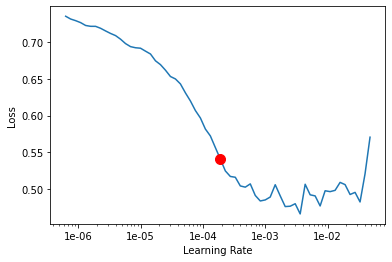

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.243860,0.207536,0.928538,0.071462,00:20


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


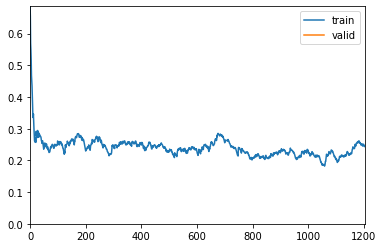

In [ ]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [ ]:
learner.save('first_cycle')

In [ ]:
seed_all(seed)
learner.load('first_cycle');

In [ ]:
learner.freeze_to(-2)
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.154659,0.133219,0.951892,0.048108,00:45


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


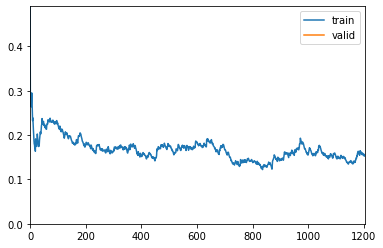

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.161359,0.133478,0.950957,0.049043,00:50


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


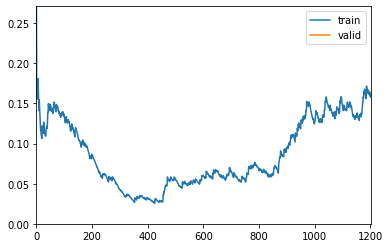

In [ ]:
learner.save('second_cycle')
seed_all(seed)
learner.load('second_cycle')
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
seed_all(seed)
learner.load('third_cycle');

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.154230,0.134562,0.951892,0.048108,01:05
1,0.044914,0.142080,0.954694,0.045306,01:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


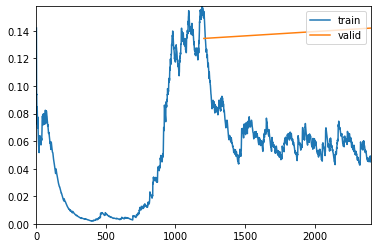

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [111]:
learner.predict('This is the best movie of 2020')

(Category 0, tensor(0), tensor([0.9943, 0.0057]))

In [112]:
learner.predict('happy new year white people elected a  president who treats women like crap and a biher disrespectful kkk suppoed white devil.')

(Category 1, tensor(1), tensor([0.3684, 0.6316]))